In [28]:
import xarray as xr


In [2]:
# !pip install dask


In [3]:
import os

directory = 'future_msl'  # Replace with your directory path
file_pattern = 'future_msl_{}_01_v1.nc'
years = range(2021, 2051)  # 2015 to 2050

# Create a list of file paths
file_paths = [os.path.join(directory, file_pattern.format(year)) for year in years]

# Open multiple files and combine them into a single dataset
ds = xr.open_mfdataset(file_paths, combine='by_coords')


In [4]:
print(ds)


<xarray.Dataset>
Dimensions:               (stations: 43119, time: 30)
Coordinates:
    station_x_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-01-01 ... 2050-01-01
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    mean_sea_level        (stations, time) float32 dask.array<chunksize=(43119, 1), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            annual_msl
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Annual mean sea level
    ...                            ...
    time_coverage_start:           2021-01-01
    time_coverage_end:             2021

In [5]:
# to dataframe
df = ds.to_dataframe()

In [6]:
print(df['mean_sea_level'].describe())


count    1.293570e+06
mean     1.394137e-01
std      8.885027e-02
min     -7.630000e-01
25%      9.900000e-02
50%      1.440000e-01
75%      1.970000e-01
max      5.060000e-01
Name: mean_sea_level, dtype: float64


In [7]:
print(ds.isnull().sum())


<xarray.Dataset>
Dimensions:         ()
Data variables:
    mean_sea_level  int32 dask.array<chunksize=(), meta=np.ndarray>


In [8]:
df.head()

station_x_coordinate  station_y_coordinate  \
stations time                                                     
0        2021-01-01                24.089                34.827   
         2022-01-01                24.089                34.827   
         2023-01-01                24.089                34.827   
         2024-01-01                24.089                34.827   
         2025-01-01                24.089                34.827   

                     mean_sea_level  
stations time                        
0        2021-01-01           0.079  
         2022-01-01           0.084  
         2023-01-01           0.089  
         2024-01-01           0.094  
         2025-01-01           0.099

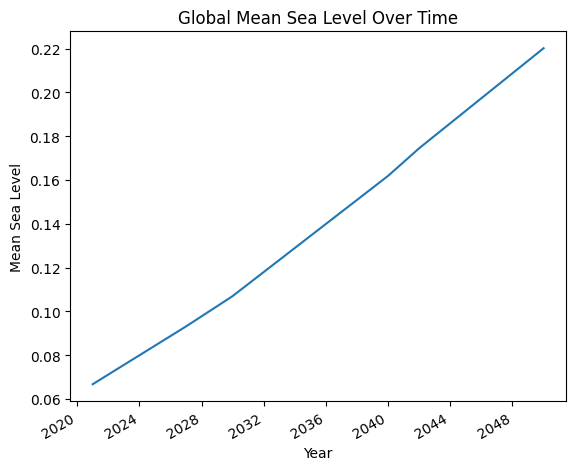

In [9]:
import matplotlib.pyplot as plt

# Assuming 'mean_sea_level' is the variable of interest
# This will calculate the mean sea level across all stations for each time point
mean_sea_level_over_time = ds['mean_sea_level'].mean(dim='stations')

# Now plot this as a simple line plot
mean_sea_level_over_time.plot()
plt.title('Global Mean Sea Level Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Sea Level')
plt.show()

# (Aggregated Across Stations)

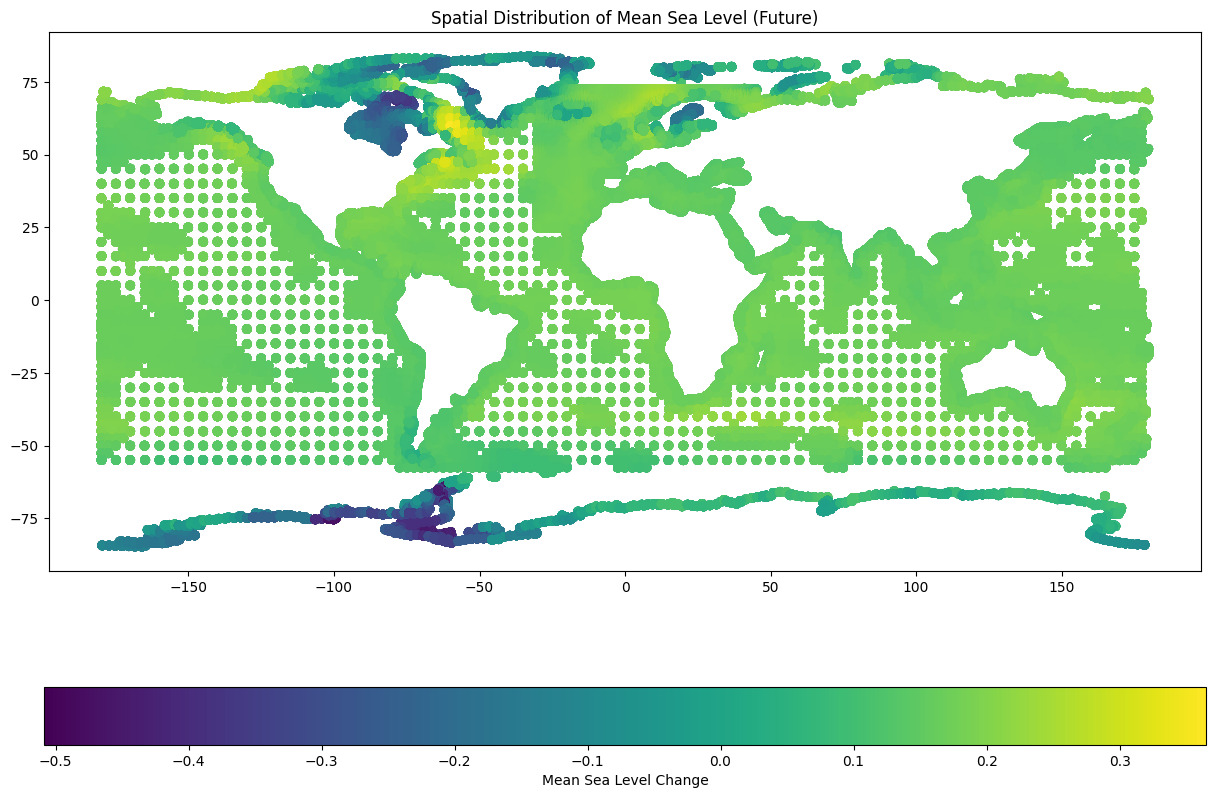

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.reset_index(),  # Reset index to ensure the DataFrame has a suitable index
    geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate)
)

# Aggregate mean sea level change per station
# This creates a new DataFrame with 'stations' as the index and the mean values as a column
station_mean_sea_level = gdf.groupby('stations')['mean_sea_level'].mean().reset_index()

# Merge this back into the original GeoDataFrame
gdf = gdf.merge(station_mean_sea_level, on='stations', suffixes=('', '_mean'))

# Now when plotting, use the new column with mean values
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='mean_sea_level_mean', ax=ax, legend=True,
         legend_kwds={'label': "Mean Sea Level Change", 'orientation': "horizontal"})
plt.title('Spatial Distribution of Mean Sea Level Change (Future)')
plt.show()


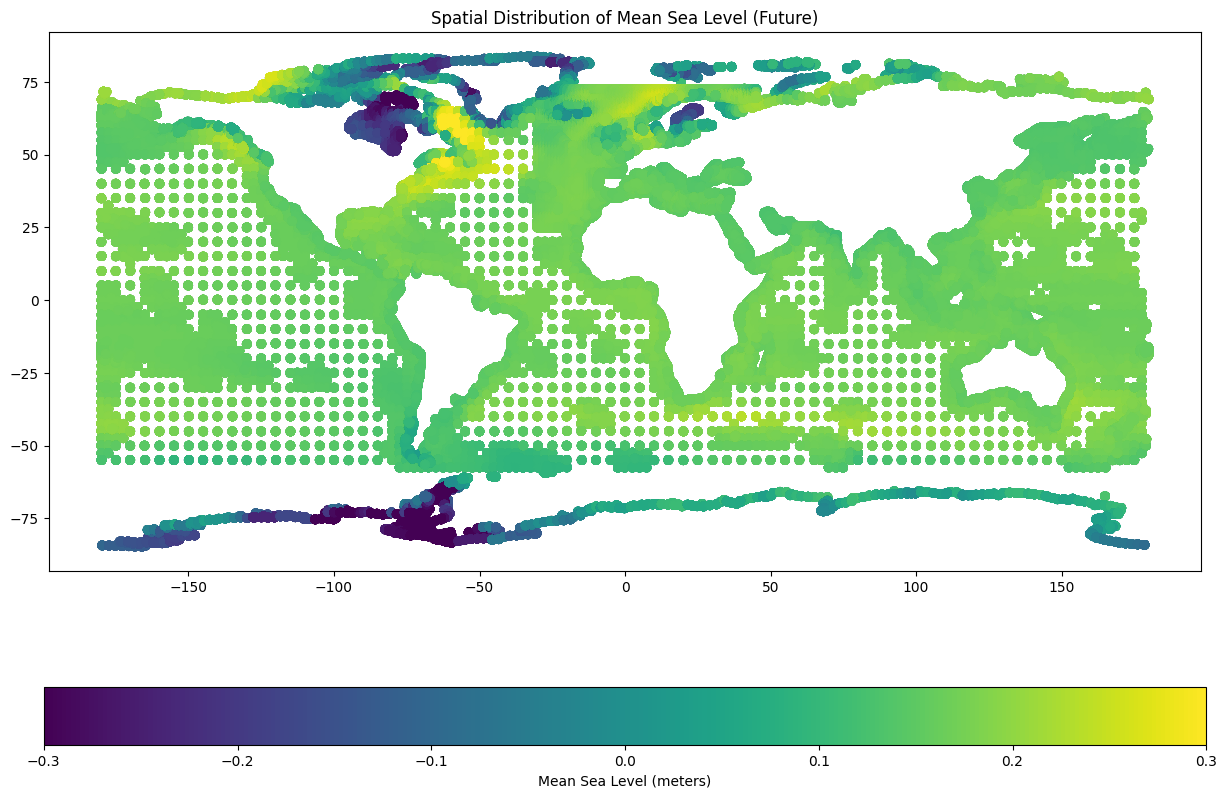

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame with the appropriate columns
# df = ...

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.reset_index(),
    geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate)
)

# Aggregate mean sea level change per station
station_mean_sea_level = gdf.groupby('stations')['mean_sea_level'].mean().reset_index()

# Merge this back into the original GeoDataFrame
gdf = gdf.merge(station_mean_sea_level, on='stations', suffixes=('', '_mean'))

# ... (other parts of the code to prepare the GeoDataFrame)

# Set a consistent color range for both plots
vmin, vmax = -0.3, 0.3  # Replace with the actual min and max values relevant to your data

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(
    column='mean_sea_level_mean',
    ax=ax,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    cmap='viridis',  # Choose a colormap that suits your data well
    legend_kwds={'label': "Mean Sea Level (meters)", 'orientation': "horizontal"}
)
plt.title('Spatial Distribution of Mean Sea Level (Future)')
plt.show()



The dataset from Copernicus Climate Change Service indeed provides time series of global sea level related variables from 1950 to 2050, based on hydrodynamic modeling with the Deltares Global Tide and Surge Model (GTSM) and climate forcing from the ERA5 reanalysis and CMIP6 high-resolution climate models. The annual mean sea level data provided are relative to the 1986-2005 reference period, considering factors like thermal expansion, changes in ocean circulation, ice sheet contributions, and glacio-isostatic adjustment.

The different scales in the historical and future datasets likely do not suggest a problem with the data's scale but reflect the acceleration in mean sea level changes, which is consistent with the high-emissions scenario SSP5-8.5 used for the future period simulations. It's important to ensure that any comparison between the two sets of data takes into account this difference in scale and the underlying assumptions of the climate projections. The metadata and documentation provided with the dataset are critical for understanding these aspects and should always be consulted for accurate data interpretation.

In [15]:
# install folium
# !pip install folium

   ---------------------------------------- 0.0/100.3 kB ? eta -:--:--
   ---------------------------------------- 100.3/100.3 kB 5.6 MB/s eta 0:00:00


In [20]:
import folium
from folium.plugins import HeatMap

# Assuming `df` is your DataFrame with the appropriate columns
# df = ...

# Prepare the data for the heatmap
# Ensure that the mean sea level data is suitable for use as a weight. It should be a positive number where higher values indicate more intensity
heatmap_data = df[['station_y_coordinate', 'station_x_coordinate', 'mean_sea_level']].dropna()

# Create a map centered around the mean latitude and longitude of your data
map_center = heatmap_data[['station_y_coordinate', 'station_x_coordinate']].mean().values.tolist()
m = folium.Map(location=map_center, zoom_start=5)

# Add the heatmap to the map. Each point in the heatmap_data will have a 'weight' given by the mean sea level
HeatMap(data=heatmap_data.values.tolist(), radius=15).add_to(m)

# Save the map to an HTML file
output_filepath = 'australia_heatmap_future.html'
m.save(output_filepath)

# Display the link to the saved HTML file if not running in a Jupyter notebook
output_filepath


'australia_heatmap_future.html'

In [34]:
import folium
from folium.plugins import HeatMap
from folium.map import LayerControl, FeatureGroup, Layer

# Assuming `df` is your DataFrame with the appropriate columns
# df = ...

# Prepare the data for the heatmap
heatmap_data = df[['station_y_coordinate', 'station_x_coordinate', 'mean_sea_level']].dropna()

# Create a map centered around the mean latitude and longitude of your data
map_center = heatmap_data[['station_y_coordinate', 'station_x_coordinate']].mean().values.tolist()
m = folium.Map(location=map_center, zoom_start=5)

# Add the heatmap to the map. Each point in the heatmap_data will have a 'weight' given by the mean sea level
HeatMap(data=heatmap_data.values.tolist(), radius=15).add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Projected Sea Level Rise Heatmap</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file
output_filepath = 'australia_heatmap_future.html'
m.save(output_filepath)

# For historical data, just change the title text accordingly:
# <b>Historical Sea Level Rise Heatmap</b>


from branca.element import Template, MacroElement



# ... (your HeatMap code here)

# Define the HTML template for the legend
template = """
{% macro html(this, kwargs) %}

<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 200px;
    height: 120px;
    z-index:9999;
    font-size:14px;
    background: white;
    border: 2px solid grey;
    padding: 10px;
    ">
    <p><b>Sea Level Rise Intensity</b></p>
    <div style="
        background-color: #F15332;
        opacity: 1.0;
        height: 10px;
        width: 10px;
        display: inline-block;
        "></div>
    <span style="margin-left: 5px;">High</span><br>
    <div style="
        background-color: #49F02C;
        opacity: 1.0;
        height: 10px;
        width: 10px;
        display: inline-block;
        "></div>
    <span style="margin-left: 5px;">Medium</span><br>
    <div style="
        background-color: #216FDF;
        opacity: 1.0;
        height: 10px;
        width: 10px;
        display: inline-block;
        "></div>
    <span style="margin-left: 5px;">Low</span>
</div>

{% endmacro %}
"""

# Create a MacroElement which will be inserted into the map
macro = MacroElement()
macro._template = Template(template)

# Add the macro element to the map
m.get_root().add_child(macro)

# Save the map to an HTML file
m.save('map_with_legend.html')



C:\Users\E\AppData\Local\Temp\ipykernel_57684\1805723909.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


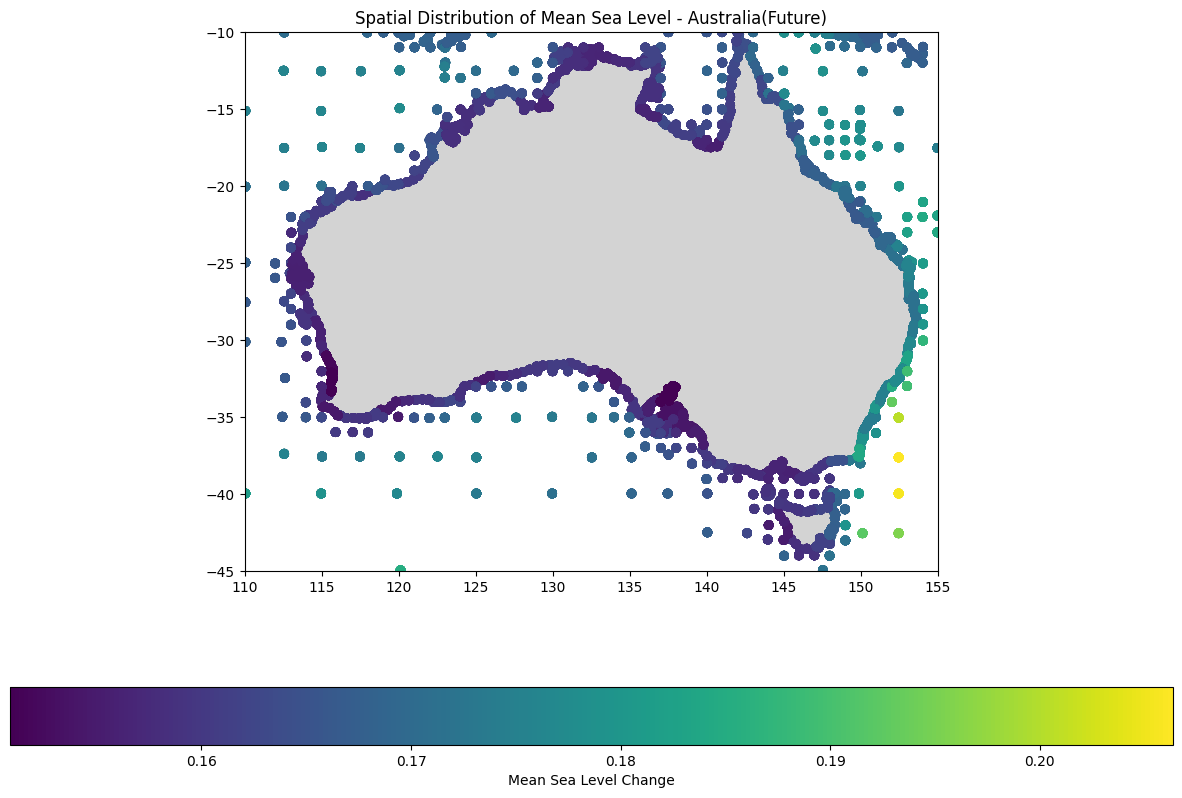

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming df is defined in your code
# df = ...

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.reset_index(),
    geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate)
)

# Aggregate mean sea level change per station
station_mean_sea_level = gdf.groupby('stations')['mean_sea_level'].mean().reset_index()

# Merge this back into the original GeoDataFrame
gdf = gdf.merge(station_mean_sea_level, on='stations', suffixes=('', '_mean'))

# Read in the built-in GeoPandas world dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Australia in the world GeoDataFrame
australia = world[world.name == "Australia"]

# Plot the world base map with Australia highlighted
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')
australia.plot(ax=ax, color='lightgrey')

# Zoom into Australia's bounding box (use the approximate coordinates)
ax.set_xlim([110, 155])
ax.set_ylim([-45, -10])

# Filter the GeoDataFrame for points within Australia's bounding box
gdf_australia = gdf.cx[110:155, -45:-10]

# Plot mean sea level change data over Australia
gdf_australia.plot(column='mean_sea_level_mean', ax=ax, legend=True,
                   legend_kwds={'label': "Mean Sea Level Change", 'orientation': "horizontal"})

plt.title('Spatial Distribution of Mean Sea Level - Australia(Future)')
plt.show()




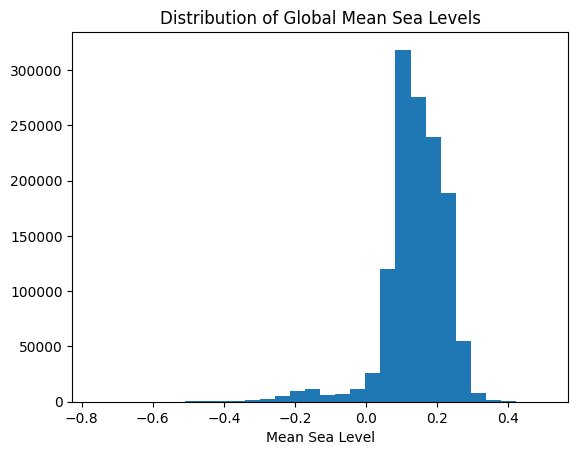

In [12]:
ds['mean_sea_level'].plot.hist(bins=30)
plt.title('Distribution of Global Mean Sea Levels')
plt.xlabel('Mean Sea Level')
plt.show()


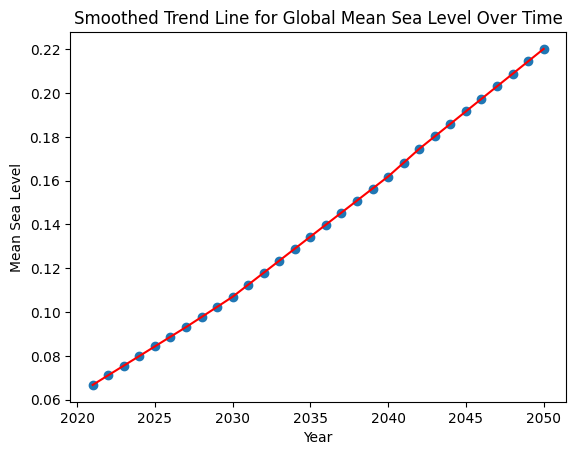

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# If 'df' has a MultiIndex, extract the level with the 'time' information
# Let's assume 'time' is at level 1 of the index
df['year'] = df.index.get_level_values('time').year

# Now that we have a 'year' column, we can proceed with the LOWESS model
# You may need to group by the 'year' and take the mean if the data has multiple entries per year
yearly_mean = df.groupby('year')['mean_sea_level'].mean().reset_index()

smoothed = lowess(yearly_mean['mean_sea_level'], yearly_mean['year'], frac=0.1)

# Create the plot
plt.plot(yearly_mean['year'], yearly_mean['mean_sea_level'], 'o')
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r-')
plt.title('Smoothed Trend Line for Global Mean Sea Level Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Sea Level')
plt.show()



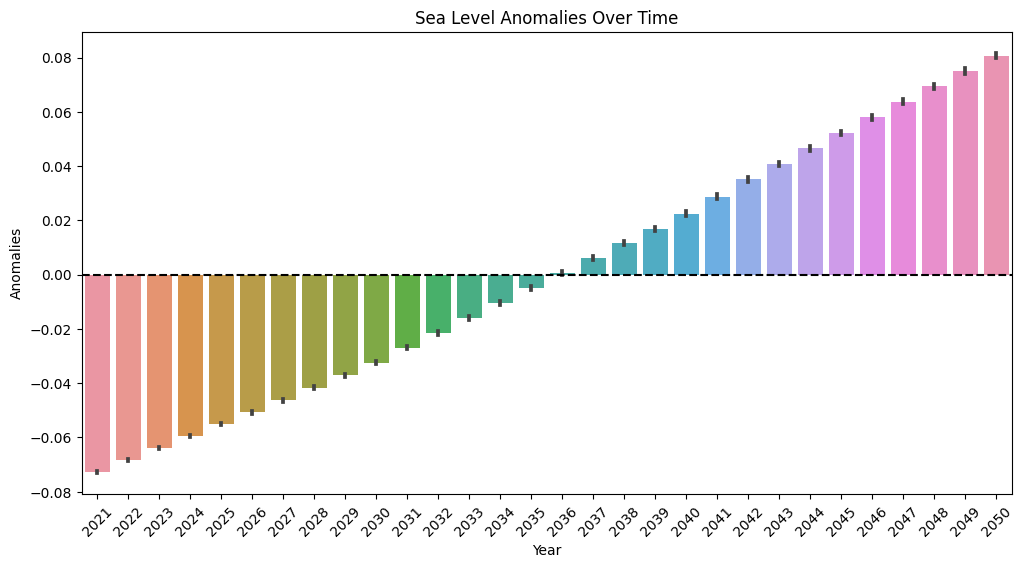

In [14]:
# Calculating the anomalies
historical_avg = df['mean_sea_level'].mean()
df['anomalies'] = df['mean_sea_level'] - historical_avg

# Plotting the anomalies
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='anomalies', data=df)
plt.axhline(0, color='k', linestyle='--')
plt.title('Sea Level Anomalies Over Time')
plt.xlabel('Year')
plt.ylabel('Anomalies')
plt.xticks(rotation=45)
plt.show()


Text(0.5, 0, 'Mean Sea Level')

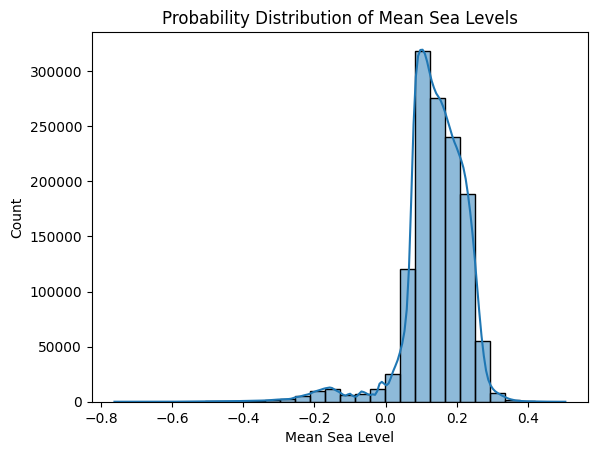

In [17]:
sns.histplot(df['mean_sea_level'], bins=30, kde=True)
plt.title('Probability Distribution of Mean Sea Levels')
plt.xlabel('Mean Sea Level')

In [19]:
df.head()

station_x_coordinate  station_y_coordinate  \
stations time                                                     
0        2021-01-01                24.089                34.827   
         2022-01-01                24.089                34.827   
         2023-01-01                24.089                34.827   
         2024-01-01                24.089                34.827   
         2025-01-01                24.089                34.827   

                     mean_sea_level  year  anomalies  
stations time                                         
0        2021-01-01           0.079  2021  -0.060414  
         2022-01-01           0.084  2022  -0.055414  
         2023-01-01           0.089  2023  -0.050414  
         2024-01-01           0.094  2024  -0.045414  
         2025-01-01           0.099  2025  -0.040414

In [ ]:
ds.close()